# Titanic Project: Will a Passenger Survive?
Group 33 Members: Chloe Vaughan, Susan Zhang, James Drover, Olivia Klassen, and Adeeb Khan

## Introduction

On the night of April 14th, 1912, the RMS Titanic struck an iceberg on her first trip in the Atlantic Ocean. Two hours and 40 minutes after the collision, the ship sank. This tragedy resulted in the loss of 1501 lives, which made up more than two-thirds of the total number of passengers and crew members (Frey et al., 2011). Less than half of the passengers survived, and of those passengers, many factors contributed to their survival or demise. Considering the many myths and ideologies surrounding the tragic incident, this project aims to observe the significance of various factors and the role they played in a passenger’s chance of survival. In this project, a dataset with information about the passengers aboard the Titanic and the status of their survival was read, wrangled, and classified in order to predict if a given passenger would have been likely to die in the accident.This analysis allows better understanding of the political environment during the which the Titanic sank. It is important to present and analyze this data so that we can think about how we might prioritize lives if a similar event were to occur. How was the lifeboat distribution prioritzied, and was it fair? Would we do things differently now, seeing as we have evolved towards equity as a society?  

[The Titanic dataset](https://www.kaggle.com/competitions/titanic/data?select=train.csv) was obtained by Kaggle. 

**Question**: Will a given passenger survive the titanic crash? To answer this question, we must first ask what variables are important to determining survival.

**Our Variables**:
- PassengerId = **NOTE**: confused about this column, ALSO some variables from this list are later removed
- Survived = whether the passenger lived or died on the Titanic, 0 = did not survive, 1 = survived
- Passenger_Class = Indicates socio-economic status, 1 = Upper, 2 = Middle, 3 = Lower
- Name = name of passenger
- Age = age in years
- Number0fSiblings = # of siblings/spouses on the titanic
- NumberofParents_children = # of parents/children on the titanic 
- Ticket = ticket number
- Fare = passenger fare
- Cabin = cabin number
- Embarked = Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

The column names given above are not the same as the untidy data. We have renamed the columns in the original dataset. Familial relationships defined as follows:
- Sibling = brother, sister, stepbrother, stepsister, Spouse = husband, wife, note that mistresses and fiancés were ignored
- Parent = mother, father, some children travelled with a nanny, NumberofParents_children = 0 in this case. Child = daughter, son, stepdaughter, stepson

### Installing Packages & Libraries

In [4]:
install.packages("tidymodels")
install.packages('themis')
install.packages('psych')
install.packages('gridExtra')

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [5]:
library(themis)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(psych)
library(gridExtra)

## Exploratory Data Analysis
Before we build our model, we need to read the data into R, then rename the columns with more intuitive names. Then, we want to become familiar with some statistics on our data (e.g. number of observations, what each column means, can columns be dropped at this step, etc). Our data is already in a tidy format, but we still need to change the class of some variables, and examine if NA values are present. These steps ensure the functions we employ later on work seamlessly, and makes the data easier to interpret.

In [6]:
boat_data <- read_csv("data/train.csv")
colnames(boat_data) = c("PassengerId", "Survived", "Passenger_Class", "Name", "Sex", "Age", "Number0fSiblings", 
                                 "NumberofParents_children", "Ticket", "Fare", "Cabin", "Embarked")
head(boat_data)

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PassengerId,Survived,Passenger_Class,Name,Sex,Age,Number0fSiblings,NumberofParents_children,Ticket,Fare,Cabin,Embarked
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


Rarely are all the variables used to build a model, inclusion of too many can negatively impact our model's accuracy. Variables are excluded for several reasons: 

- 1) they may be a poor predictor of our target variable survival status 
- 2) too many NA values may be present and we have little data to work with 
- 3) the data collected is irrelevant, e.g. name, or enumeration of each entry in the data set

In a later step, we run forward selection to determine which predictors are good ones. Right now, we only drop variables based on criteria 2) and 3). Table 1 shows detailed summary statistics for each variable. 

In [7]:
nrow(boat_data)

[1] 891

In [8]:
describe(boat_data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PassengerId,1,891,446.0000000,257.3538420,446.0000,446.0000000,330.61980,1.00,891.0000,890.0000,0.000000e+00,-1.2040412,8.62167810
Survived,2,891,0.3838384,0.4865925,0.0000,0.3548387,0.00000,0.00,1.0000,1.0000,4.769135e-01,-1.7745414,0.01630146
Passenger_Class,3,891,2.3086420,0.8360712,3.0000,2.3856942,0.00000,1.00,3.0000,2.0000,-6.284264e-01,-1.2834293,0.02800944
Name*,4,891,446.0000000,257.3538420,446.0000,446.0000000,330.61980,1.00,891.0000,890.0000,0.000000e+00,-1.2040412,8.62167810
Sex*,5,891,1.6475870,0.4779901,2.0000,1.6844320,0.00000,1.00,2.0000,1.0000,-6.168385e-01,-1.6213262,0.01601327
Age,6,714,29.6991176,14.5264973,28.0000,29.2692308,13.34340,0.42,80.0000,79.5800,3.874744e-01,0.1597671,0.54364050
Number0fSiblings,7,891,0.5230079,1.1027434,0.0000,0.2720898,0.00000,0.00,8.0000,8.0000,3.682919e+00,17.7269083,0.03694329
NumberofParents_children,8,891,0.3815937,0.8060572,0.0000,0.1823282,0.00000,0.00,6.0000,6.0000,2.739868e+00,9.6880847,0.02700393
Ticket*,9,891,339.5173962,200.8342670,338.0000,339.6465638,268.35060,1.00,681.0000,680.0000,5.569478e-05,-1.2817773,6.72820110


**Table 1.** Summary Statistics for all Columns in Dataset

Two variables under the count (n) column catch our eye; both Age and Cabin have quite a few NA values. We have decided to remove "Cabin" as a predictor because only 204 out of 891 observations (23%) are not NA (Table 1). In contrast, 80% of the age data is not NA, thus we keep age as a predictor. 

Some variables have drastically different scales, highlighting the importance of scaling to ensure each predictor has equal say. Also, the mean survival value is 38%, suggesting that most people did not survive the crash.

We decided to drop Name, Ticket, and PassengerId as these variables contain information that is not relevant to our predictions. The Name, Ticket and passengerId are arbitrary, they do not hold information that will have a big impact. Below we remove the irrelevant predictors. 

In [9]:
#getting rid of PassengerId,Name, Embarked,Ticket and Cabin:
boat_data_selected <- boat_data |>
    select(-PassengerId,-Name, -Ticket, -Cabin)

Two additional columns are added, one to turn sex into binary (1 = male, 0 = female), and another that converts the port of embarkation into numerical values (0 = Southampton, 1 = Cherbourg, 2 = Queenstown). We also remove NA values from age, and convert survived into a factor. The data type of each column is important to ensure visualizations can be made from them.

In [10]:
#adding a column for sex in binary and making the embarked column into numeric(for it to work with the knn model)

boat_data_binary <- boat_data_selected |>
    mutate(sex_binary = ifelse(Sex == "male", 1, ifelse(Sex == "female", 0, NA))) |>
    mutate(Embarked_numeric = ifelse(Embarked == "S", 0, ifelse(Embarked == "C", 1, ifelse(Embarked == "Q", 2, NA))))

boat_data_NA <- boat_data_binary |>
    filter(!is.na(Age)) |>
    mutate(Survived = as_factor(Survived))

Before we begin exploratory data analysis, our data set has to be split. If we use testing data to build our model, we will not get a good evaluation of our model's accuracy. It already has "experience" with such data, thus we split our data into two sets; 70% to train our model, 30% to test it on.

In [11]:
set.seed(911)
#splitting the wrangled data into test and training sets
#we chose a 70-30 percent split to ensure our model is accurate at the same time as making sure the testing is accurate.

boat_split <- initial_split(boat_data_NA, prop = 0.7, strata = Survived)
boat_train <- training(boat_split)
boat_test <- testing(boat_split)

As of now, we have 7 possible predictors to determine "survived": Passenger_class, Sex, Age, Number0fSiblings, NumberofParents_children, Fare, and Embarked. The 7 figures below visualize the relationship between each of these predictors and survival status. 

Warning message:
“Removed 10 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_bin()`).”


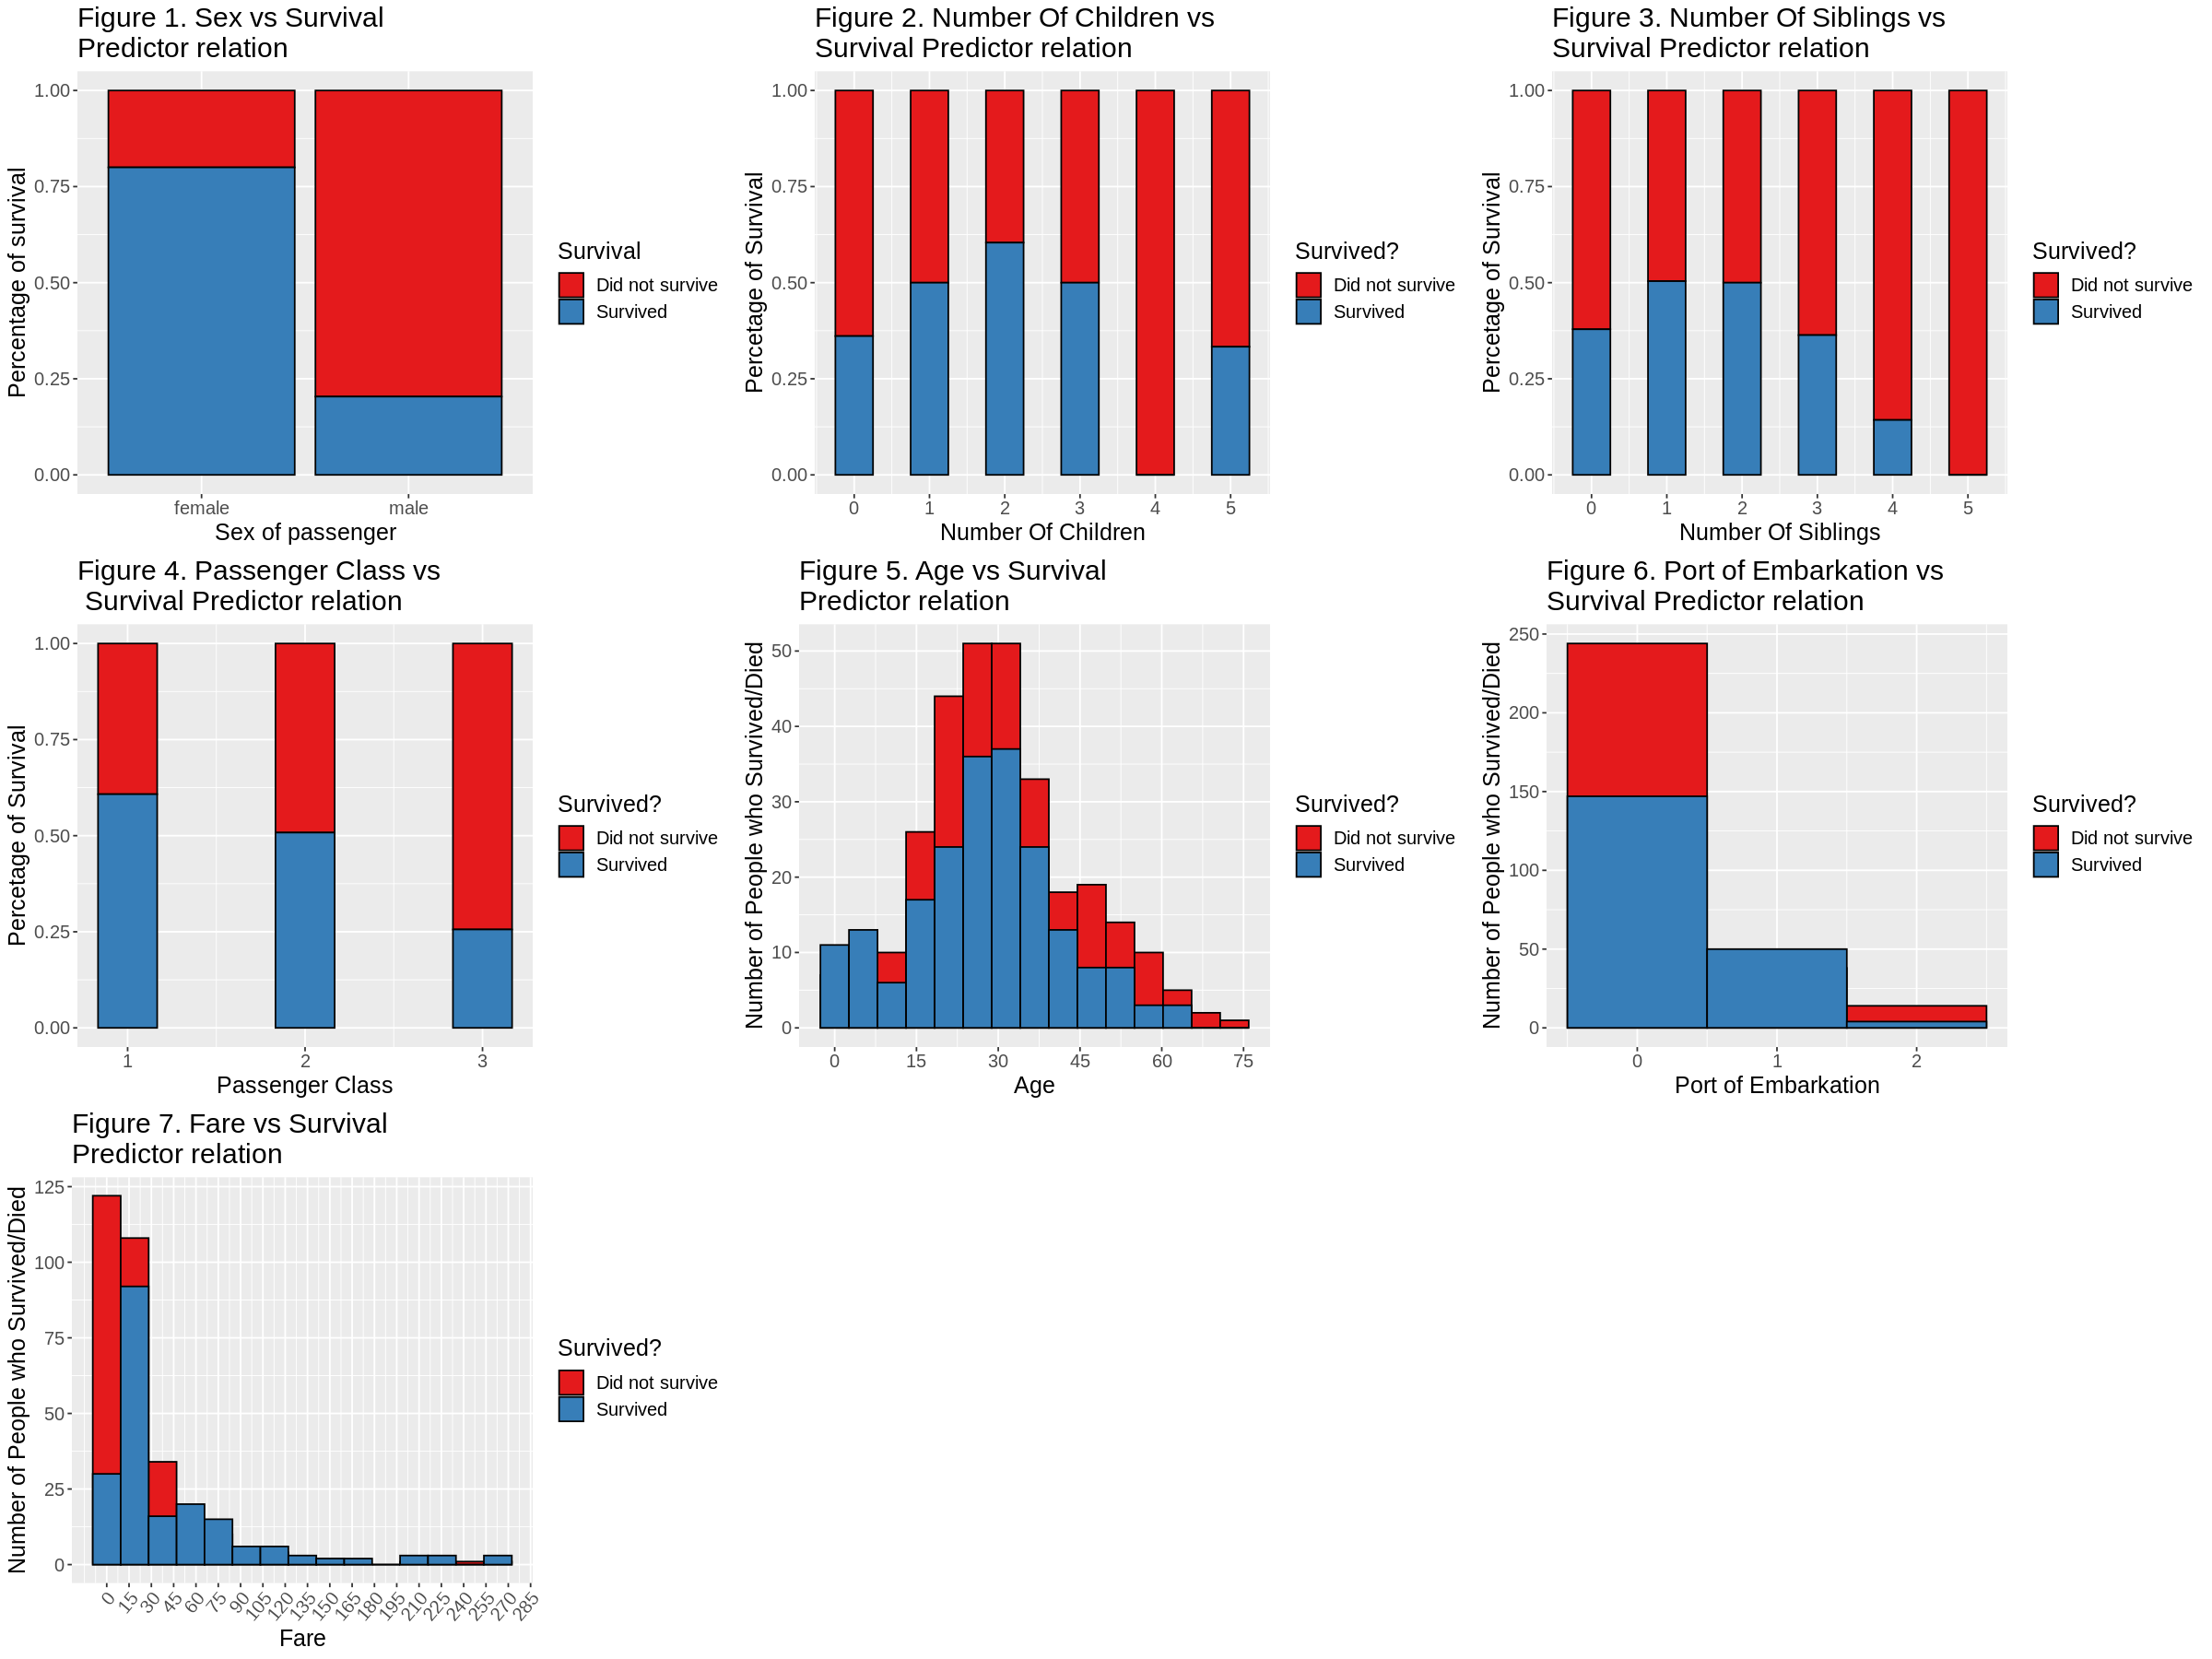

In [12]:
temp_data_graph <- boat_train |>
    mutate(Survived_char = ifelse(Survived == 1, "Survived", ifelse(Survived == 0, "Did not survive", NA)))

survival_bar_plot_sex <- ggplot(temp_data_graph, aes(x = Sex, fill = as_factor(Survived_char))) +
    geom_bar(position = "fill", col = "black") +
    labs(x = "Sex of passenger", y = "Percentage of survival", fill = "Survival") +
    ggtitle("Figure 1. Sex vs Survival \nPredictor relation") +
    scale_fill_brewer(palette = "Set1") + 
    theme(text=element_text(size=15)) #Fare not yet explored

NOC_survival <- temp_data_graph |>
    ggplot(aes(x = NumberofParents_children, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 11, position = "fill", col = "black") +
    labs(x = "Number Of Children", y = "Percetage of Survival", fill = "Survived?") + 
    scale_x_continuous(breaks = c(0, 1, 2,3,4,5)) +
    ggtitle("Figure 2. Number Of Children vs \nSurvival Predictor relation") +
    scale_fill_brewer(palette = "Set1") + 
    theme(text=element_text(size = 15))

NOS_survival <- temp_data_graph |>
    ggplot(aes(x = Number0fSiblings, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 11, position = "fill", col = "black") +
    labs(x = "Number Of Siblings", y = "Percetage of Survival", fill = "Survived?") + 
    scale_x_continuous(breaks = c(0, 1, 2,3,4,5)) +
    ggtitle("Figure 3. Number Of Siblings vs \nSurvival Predictor relation") +
    scale_fill_brewer(palette = "Set1") +
    theme(text=element_text(size = 15))

class_survival <- temp_data_graph |>
    ggplot(aes(x = Passenger_Class, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 7, position = "fill", col = "black") +
    labs(x = "Passenger Class", y = "Percetage of Survival", fill = "Survived?") + 
    scale_x_continuous(breaks = c(0, 1, 2,3)) +
    ggtitle("Figure 4. Passenger Class vs \n Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") + 
    theme(text=element_text(size = 15))

AgevSurvived <- temp_data_graph |>
    ggplot(aes(x = Age, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 15, position = "identity", col = "black") +
    labs(x = "Age", y = "Number of People who Survived/Died", fill = "Survived?")+
    scale_x_continuous(breaks = seq(from = 0, to = 80, by = 15)) + 
    ggtitle("Figure 5. Age vs Survival \nPredictor relation") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

EmbarkedvSurvived <- temp_data_graph |>
    ggplot(aes(x = Embarked_numeric, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 3, position = "identity", col = "black") +
    labs(x = "Port of Embarkation", y = "Number of People who Survived/Died", fill = "Survived?")+
    scale_x_continuous() + 
    ggtitle("Figure 6. Port of Embarkation vs \nSurvival Predictor relation") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

FarevSurvived <- temp_data_graph |> filter(Fare <275) |>
    ggplot(aes(x = Fare, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 15, position = "identity", col = "black") +
    labs(x = "Fare", y = "Number of People who Survived/Died", fill = "Survived?")+
    scale_x_continuous(breaks = seq(from = 0, to = 285, by = 15)) + 
    ggtitle("Figure 7. Fare vs Survival \nPredictor relation") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15)) +
     theme(axis.text.x = element_text(angle = 50, hjust = 1))

options(repr.plot.width = 20, repr.plot.height = 15)
grid.arrange(survival_bar_plot_sex, NOC_survival, NOS_survival, class_survival, AgevSurvived, EmbarkedvSurvived, FarevSurvived)

## Methods

Using our cleaned up Titanic dataset, we build a K-Nearest Neighbours Classification model to predict whether a passenger survived or not. This model operates by identifying the K nearest points to a new observation, then determines the survival status of a new observation by majority vote. Our predictors for identifying the K-nearest neighbours will be determined by forward selection, which sequentially addes predictors into our model's recipe then calculates the accuracy for each one. Identifying the best predictors is important, usage of irrelevant predictors induces random influence which corrupts the set of nearest neighbours to lower our model's accuracy. 

Following forward selection, we code our recipe using the predictors identified as well as the engine. We then run cross-validation to select the most accurate K value. The number of values we use to calculate the majority class will influence our end result, thus we try to pick a K value that maximizes accurcacy. Cross-validation is the ideal way to accomplish this because the accuracy is evaluated on a data set that was not used to build the model. Along with forward selection, cross-validation is another strategy to optimize our model. 

We then use the predictors and K value identified to code our final model, and evalute its accuracy on the testing data. The percent accuracy of our model is a poor indicator of whether our model is good or not without a comparison. The baseline for any classification problem is the majority classifier, which will guess the majority classifier (0, dead in our case) regardless of the predictors' values. If our accuracy is greater than  

## Predictor Variable Selection

In [13]:
set.seed(911)

boat_train_model <- boat_train |>
    select(-Sex)
#Now we start the process of developing a model to predict weather a given passenger survived the titanic crash.

boat_spec_tune <- knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

boat_vfold <- vfold_cv(boat_train_model, v = 10, strata = Survived)
k_vals <- tibble(neighbors = seq(from = 1, to = 35, by = 2))


In [14]:
set.seed(911)

names <- c("Passenger_Class", "Age", "Number0fSiblings", "NumberofParents_children", "Fare","sex_binary","Embarked_numeric")

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())


# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Survived", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        boat_recipe <- recipe(as.formula(model_string), 
                                data = boat_train_model) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(boat_recipe) |>
          add_model(boat_spec_tune) |>
          tune_grid(resamples = boat_vfold, grid = k_vals) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

ERROR: [1m[33mError[39m in `check_installs()`:[22m
[33m![39m Some package installs are required: 
[36m•[39m 'kknn', 'kknn'


**Table 2.** Forward Selection Results. Table 2 suggests that using Fare, Sex_binary, Passenger_class, Age, Number0fSiblings, NumberofParents_children will give us the best accuracy. 

Our top three predictors are Fare, Sex, and Passenger  (Table 2), which comes as no surprise given that the Titanic was designed for luxury customers. What is interesting is that gender appears to play a bigger role than age, sibling status, and the parent/child ratio. Including port of embarkation actually negatively impacts our model, even though Figure 6 suggests there is a relationship between port embarked and survival. Below we build our model and recipe.

## Creating Initial Classification Engine & Finding the Best K Value

In [ ]:
#tuning the model to find the best value of k using the best predictors as seen above.

boat_recipe <- recipe(Survived ~ Fare +sex_binary + Passenger_Class + Age + Number0fSiblings, data = boat_train_model) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

boat_model_stats <- workflow() |>
  add_recipe(boat_recipe) |>
  add_model(boat_spec_tune) |>
  tune_grid(resamples = boat_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")
 
boat_model_stats 

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

accuracy_versus_k <- ggplot(boat_model_stats, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line(color = "blue") +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 35, by = 2))
       scale_y_continuous(limits = c(0.4, 1.0))

accuracy_versus_k

**Figure 8.** Cross-Validation K Values Plot. The best accuracy is when K=5. 

## Creating Final Model

In [ ]:
set.seed(911)
#pulling the max value of k and retraining the model with given k:

kmax <- boat_model_stats|>
    filter(mean == max(mean)) |>
    pull(neighbors)

boat_spec <- knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmax) |>
  set_engine("kknn") |>
  set_mode("classification")

boat_fit <- workflow() |>
  add_recipe(boat_recipe) |>
  add_model(boat_spec) |>
  fit(data = boat_train_model)

kmax

In [ ]:
set.seed(911)
#testing the model's accuracy on testing data:

accuracy_estimate <- predict(boat_fit, boat_test) |>
    bind_cols(boat_test) |>
    metrics(truth = Survived, estimate = .pred_class) |>
    filter(.metric == "accuracy")

accuracy_estimate

In [ ]:
#finding the majority class prediction:

majority_class <- boat_test |>
    group_by(Survived) |>
    summarise(count = n(), percentage = n()/nrow(boat_test))

majority_class

In [ ]:
predictions <- predict(boat_fit, boat_test) |>
    bind_cols(boat_test)


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)

confusion_matrix <- predictions |>
    conf_mat(truth = Survived, estimate = .pred_class)

confusion_matrix

autoplot(confusion_matrix,type = "heatmap", Truth ="")

**Figure 9.** Confusion matrix of our model's accuracy. For passengers that died, 106 predictions were correct out of 126. 67 were correctly predicted to survive out of 89 total.

## Final Analysis of our Model

In [ ]:
#slighly more accurate for males due to more males being in the training set

predictions %>%
group_by(sex_binary, Survived == .pred_class) %>%
summarize(count = n()) %>%
mutate(prop = count/sum(count))


**Table 10.**

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 10)

predictions %>%
group_by(Passenger_Class, is_accurate = Survived == .pred_class) %>%
summarize(count = n()) %>%
mutate(prop = count/sum(count)) %>%
filter(is_accurate) %>%
ggplot()+
geom_bar(aes(x = Passenger_Class, y = prop), stat = "identity", fill = "deepskyblue") + 
labs(x = "Passenger Class", y = "Percentage of survival") +
ggtitle("Figure 8. Passenger Class vs Percentage of survival plot") + 
theme(text=element_text(size = 15))


**Figure 11.**

In [ ]:
#Fare

FarevPredicted <- predictions |> mutate(accuracy =  Survived == .pred_class) |> filter(Fare <150) |>
    ggplot(aes(x = Fare, fill = as_factor(accuracy))) +
    geom_histogram(bins = 10, col = "black") +
    labs(x = "Fare", y = "Number of People at that fare", fill = "Accurately precited?")+
    scale_x_continuous(breaks = seq(from = 0, to = 275, by = 20)) + 
    ggtitle("Figure 9. Fare vs Accuracy Prediction accuracy") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

FarevPredicted

**Figure 12.**

In [ ]:
sexvPredicted <- predictions |> mutate(accuracy =  Survived == .pred_class) |>
    ggplot(aes(x = Sex, fill = as_factor(accuracy))) +
    geom_bar(bins = 2, col = "black") +
    labs(x = "Sex", y = "Number of People of given sex", fill = "Accurately predicted?") +
    ggtitle("Figure 10. Sex vs Accuracy Prediction accuracy") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

sexvPredicted

**Figure 13.**

## Discussion

## References

Frey, B. S., Savage, D. A., & Torgler, B. (2011). Behavior under Extreme Conditions: The Titanic Disaster. Journal of Economic Perspectives, 25(1), 209–222. https://doi.org/10.1257/jep.25.1.209

Hall, W. (1982) Social Class and Survival on the S.S. Titanic. Social Science & Medicine, 22(6), 687-690.  https://doi.org/10.1016/0277-9536(86)90041-9  

Titanic - Machine learning from disaster. (n.d.). Kaggle. https://www.kaggle.com/competitions/titanic/data?select=train.csv